# Library

In [1]:
import requests
from bs4 import BeautifulSoup

import time
import datetime
from datetime import datetime, timedelta
import re

import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

art_project_path = '/content/drive/MyDrive/Art/Art_Project'

# Sites' list for parsing

In [2]:
urls_news = ['https://artguide.com/', 'http://artuzel.com/', 'https://www.theartnewspaper.ru/']
# https://artguide.com/ - <div class="chromeframe">
#    Ваш браузер <em>устарел!</em> <a href="http://browsehappy.com/">Установите другой браузер</a> или
#    <a href="http://www.google.com/chromeframe/?redirect=true">Google Chrome Frame</a>, чтобы просматривать этот сайт.
urls_datasets = ['https://artchive.ru/', 'https://artinvestment.ru/']
urls_archives = ['https://russianartarchive.net/ru'] # есть API - https://api.raan.garagemca.org/documentation/#/
urls_fairs = ['https://www.cosmoscow.com/ru/']

# Unused code

# Functions
correct:
- speed counting messages
- fix labels in some graphics

## Openings and savings
4. __open_parsing_dict()__ -> parsing_dict - Open dict with sites for parsing
5. __open_page_stat()__ -> page_stat - Open page_parsing_status.csv
6. __open_pages_counter_stat(file)__ -> pages_counter_stat - Open artinvest_pages_counter_stat.csv
7. __open_news_articles_data(file)__ -> news_articles_data - Open artinvest_news_articles_data.csv


12. __open_long_text(file)__ -> long_text_df - Open artinvest_long_text.csv
13. __open_long_text_url_list_temp()__ -> parsing_list - Open json artinvest_long_text_url_list_temp
14. __save_long_text_url_list_temp(parsing_list)__ -> - Save json artinvest_long_text_url_list_temp
17. __save_df_file(df, file)__ -> - Save df to csv file

In [3]:
# 4. Open dict with sites for parsing
def open_parsing_dict():
  with open(art_project_path + '/sites_for_parsing.txt', 'rb') as infile:
    parsing_dict = json.load(infile)
  return parsing_dict

# 5. Open page_parsing_status.csv
def open_page_stat():
  page_stat = pd.read_csv(art_project_path + '/page_parsing_status.csv')
  return page_stat

artinvest_s = '/artinvest_pages_counter_stat.csv'
artinvest_d = '/artinvest_news_articles_data.csv'
theartnewspaper_d = '/theartnewspaper_data_new.csv'

# 6. Open pages_counter_stat.csv
def open_pages_counter_stat(file):
  pages_counter_stat = pd.read_csv(art_project_path + file)
  return pages_counter_stat

# 7. Open news_articles_data.csv
def open_news_articles_data(file):
  news_articles_data = pd.read_csv(art_project_path + file)
  return news_articles_data

# 17. Save df to csv file
def save_df_file(df, file):
  df.to_csv(art_project_path + file, index=False)

In [4]:
artinvest_lt = '/artinvest_long_text.csv'
theartnewspaper_lt = '/theartnewspaper_long_text.csv'

# 12. Open long_text.csv
def open_long_text(file):
  long_text_df = pd.read_csv(art_project_path + file)
  return long_text_df

# 13. Open json long_text_url_list_temp
def open_long_text_url_list_temp():
  with open(art_project_path + '/long_text_url_list_temp.txt', 'rb') as infile:
    parsing_list = json.load(infile)
  return parsing_list

# 14. Save json long_text_url_list_temp
def save_long_text_url_list_temp(parsing_list):
  with open(art_project_path + '/long_text_url_list_temp.txt', 'w') as outfile:
    json.dump(parsing_list, outfile)

## Data mining
1. __get_page(url)__ -> bs_page, page_parsing_status.csv - Collect request status


8. __get_artinvest_pages_counter_stat()__ -> - Parsing artinvest_pages_counter_stat ___and___ current artinvest_news_articles_data parsing ___and___ artinvest_long_text.csv
9. __get_artinvest_pages_curr_data(url)__ -> - Parsing current artinvest_news_articles_data
10. __get_artinvest_news_articles_archive()__ -> - Parsing artinvest_news_articles_data ARCHIVE
11. __def get_long_text()__ -> - Parsing long texts


15. __long_text_problems_fix()__ - Fixing long text problems


18. __date_transfomation(cell)__ -> cell - Date transfomation

In [5]:
# 1. Collect request status - saving every get result

def get_page(url):
  start_time = time.time()
  try:
    response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'}) # timeout=0.001
# Edge/97.0.1072.55
# Chrome/97.0.4692.71
    get_page_stat_new = pd.DataFrame({'page_url': [url],
                                      'status_code': [response.status_code],
                                      'encoding': [response.encoding],
                                      'raise_for_status': [response.raise_for_status()],
                                      'parsing_date': [datetime.now().date()],
                                      'parsing_time': [datetime.now().time()],
                                      'parsing_sec_speed': [time.time() - start_time]})

    bs_page = BeautifulSoup(response.text, 'html.parser')
    return bs_page

  except HTTPError: # HTTPError: 503 Server Error: Service Temporarily Unavailable for url: https://artinvestment.ru/news/artnews/
    get_page_stat_new = pd.DataFrame({'page_url': [url],
                                      'status_code': [response.status_code],
                                      'encoding': [response.encoding],
                                      'raise_for_status': [response.raise_for_status()],
                                      'parsing_date': [datetime.now().date()],
                                      'parsing_time': [datetime.now().time()],
                                      'parsing_sec_speed': [time.time() - start_time]})
    
  finally:
    get_page_stat = open_page_stat() # 5. Open page_parsing_status.csv
    get_page_stat = pd.concat([get_page_stat, get_page_stat_new])

    get_page_stat.to_csv(art_project_path + '/page_parsing_status.csv', index=False)

In [6]:
# 8. Parsing artinvest_pages_counter_stat and current artinvest_news_articles_data parsing

# 8.1 Get links list
def get_parsing_links_list():
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  parsing_links_list = []
  for s in sites['artinvestment.ru']['news']['links']:
    parsing_links_list.append(s)
  for s in sites['artinvestment.ru']['articles']['links']:
    parsing_links_list.append(s)
  return parsing_links_list

# 8.2 Get titles list
def get_parsing_titles_list():
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  parsing_titles_list = []
  for s in sites['artinvestment.ru']['news']['titles']:
    parsing_titles_list.append(s)
  for s in sites['artinvestment.ru']['articles']['titles']:
    parsing_titles_list.append(s)
  return parsing_titles_list

# 8.3 Parsing artinvest_pages_counter_stat - saving last parsing results from the first pages
def get_artinvest_pages_counter_stat(file):
  begining_p = time.time()
  parsing_speed_p = 0
  artinvest_pages_counter_stat = open_pages_counter_stat(file) # 6. Open pages_counter_stat.csv
  artinvest_pages_counter_stat['parsing_date'] = artinvest_pages_counter_stat['parsing_date'].dropna().apply(lambda x: date_transfomation(x))
  parsing_links_list = get_parsing_links_list() # 8.1 Get links list
  parsing_titles_list = get_parsing_titles_list() # 8.2 Get titles list

  parsing_speed_p = parsing_speed_p + (time.time() - begining_p)
  for link in parsing_links_list:
    link_page = get_page(link) # 1. Collect request status
    start_time = time.time()
    try: # never problems happen only None result
      table_blocks = link_page.find_all('div', class_='pager')
    except: continue
    else: # problems can start from here
      artinvest_pages_counter_stat_new = pd.DataFrame({'page_url': [link],
                                                       'page_title': [parsing_titles_list[parsing_links_list.index(link)]],
                                                       'records_total': [int(table_blocks[0].find_all('em')[0].text)],
                                                       'pages_total': [int(table_blocks[0].find_all('em')[1].text)],
                                                       'records_max': [int(table_blocks[0].find('input').get('title').split(' ')[1])],
                                                       'records_value': [int(table_blocks[0].find('input').get('value'))],
                                                       'first_page_url': [table_blocks[0].find('a').get('href')],
                                                       'parsing_date': [datetime.now().date()],
                                                       'parsing_time': [datetime.now().time()],
                                                       'parsing_sec_speed': [time.time() - start_time]
                                                       })
      artinvest_pages_counter_stat = pd.concat([artinvest_pages_counter_stat, artinvest_pages_counter_stat_new])
      parsing_speed_p = parsing_speed_p + (time.time() - start_time)
      
      # 9. Parsing current artinvest_news_articles_data
      get_artinvest_pages_curr_data(artinvest_d, link, link_page, parsing_titles_list, parsing_links_list)

  artinvest_pages_counter_stat.drop_duplicates(subset = ['page_url', 'parsing_date'], keep = 'last', inplace = True)
  new_pages_count = artinvest_pages_counter_stat.loc[artinvest_pages_counter_stat['parsing_date']==artinvest_pages_counter_stat['parsing_date'].max()]['page_url'].count()

  #artinvest_pages_counter_stat.to_csv(art_project_path + file, index=False)
  save_df_file(artinvest_pages_counter_stat, file)

  return print('{} new pages have been collected\nin {} seconds\nAll pages have been collected - {}'.format(new_pages_count, parsing_speed_p, (new_pages_count==len(parsing_links_list))))

In [7]:
# 9. Parsing current artinvest_news_articles_data - saving last parsing results from the first pages

def get_artinvest_pages_curr_data(file, page_url, page, parsing_titles, parsing_links):
  begining_a = time.time()
  parsing_speed_a = 0
  artinvest_news_articles_data = open_news_articles_data(file) # 7. Open news_articles_data.csv
  artinvest_news_articles_data['parsing_date'] = artinvest_news_articles_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x))

  try: # never problems happen only None result
    start_time = time.time()
    list_advices = page.find_all('ul', class_='list advices')
  except: pass
  else: # problems can start from here
    dates_list = []
    for em in list_advices[0].find_all('em'):
      dates_list.append(em.text)
    links_list = []
    titles_list = []
    for a in list_advices[0].find_all('a'):
      if re.compile('\d+').search(str(a.get('href')))is not None:
        links_list.append(a.get('href'))
      if a.get('title') is not None:
        titles_list.append(a.get('title'))
    short_text_list = []
    for span in list_advices[0].find_all('span')[1::2]:
      short_text_list.append(span.text)

    artinvest_news_articles_data_new = pd.DataFrame({'date': dates_list,
                                                     'link': links_list,
                                                     'title': titles_list,
                                                     'short_text': short_text_list,
                                                    })
    artinvest_news_articles_data_new['page_url'] = page_url
    artinvest_news_articles_data_new['page_title'] = parsing_titles[parsing_links.index(page_url)]
    artinvest_news_articles_data_new['parsing_date'] = datetime.now().date()
    artinvest_news_articles_data_new['parsing_time'] = datetime.now().time()
    artinvest_news_articles_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

    # For parsing long texts
    artinvest_news_articles_data_new['long_text_url'] = artinvest_news_articles_data_new['page_url'] + artinvest_news_articles_data_new['link']
    long_text_url_list_new = artinvest_news_articles_data_new['long_text_url'].tolist()
    long_text_url_list = artinvest_news_articles_data['long_text_url'].tolist()
    long_text_url_list_temp = list(set(long_text_url_list_new) - set(long_text_url_list)) # only new urls - temporal list
    save_long_text_url_list_temp(long_text_url_list_temp) # 14. Save json long_text_url_list_temp

    collected_pages_a_count = artinvest_news_articles_data_new['page_url'].count()
    artinvest_news_articles_data = pd.concat([artinvest_news_articles_data, artinvest_news_articles_data_new])
    artinvest_news_articles_data.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
    parsing_speed_a = parsing_speed_a + (time.time() - begining_a)
    
    #artinvest_news_articles_data.to_csv(art_project_path + file, index=False)
    save_df_file(artinvest_news_articles_data, file)

    time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
    get_long_text(artinvest_lt) # 11. Parsing long texts

    return print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, parsing_speed_a))

In [8]:
# 11. Parsing long texts - saving only new results from the first pages
    
def get_long_text(file):
  begining_t = time.time()
  parsing_speed_t = 0
  artinvest_long_text_df = open_long_text(file) # 12. Open long_text.csv
  long_text_url_list = open_long_text_url_list_temp() # 13. Open json long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      text_block = text_page.find('div', class_='block content-data article-content')
      text_all = text_block.find_all('p')
      text_list = []
      for p in text_all:
        text_list.append(p.text)
      long_text_list.append(text_list)
    except: 
      text_list = []
      long_text_list.append(text_list)
    try:
      sourse_all = text_block.find('p', class_='mat2left').find_all('a')
      sourses = []
      for a in sourse_all:
        sourses.append(a.get('href'))
      sourses_list.append(sourses)
    except: 
      sourses = []
      sourses_list.append(sourses)
    finally:
      parsing_speed_list.append(time.time() - start_time)

  artinvest_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list,
                                             'long_text': long_text_list,
                                             'sourses': sourses_list,
                                             'parsing_sec_speed_2': parsing_speed_list # for long_text collection without getting page
                                            })
  
  collected_pages_t_count = artinvest_long_text_df_new['long_text_url'].count()
  artinvest_long_text_df = pd.concat([artinvest_long_text_df, artinvest_long_text_df_new])
  artinvest_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t = parsing_speed_t + (time.time() - begining_t)

  #artinvest_long_text_df.to_csv(art_project_path + file, index=False)
  save_df_file(artinvest_long_text_df, file)

  return print('{} text pages have been collected\nin {} seconds\nAll text pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

# 11.1 Parsing problematic long texts

def get_long_text_problems(file, long_text_url_list):
  begining_t = time.time()
  parsing_speed_t = 0
  artinvest_long_text_df = open_long_text(file) # 12. Open long_text.csv
  #long_text_url_list = open_long_text_url_list_temp() # 13. Open json artinvest_long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      text_block = text_page.find('div', class_='block content-data article-content')
      text_all = text_block.find_all('p')
      text_list = []
      for p in text_all:
        text_list.append(p.text)
      long_text_list.append(text_list)
    except: 
      text_list = []
      long_text_list.append(text_list)
    try:
      sourse_all = text_block.find('p', class_='mat2left').find_all('a')
      sourses = []
      for a in sourse_all:
        sourses.append(a.get('href'))
      sourses_list.append(sourses)
    except: 
      sourses = []
      sourses_list.append(sourses)
    finally:
      parsing_speed_list.append(time.time() - start_time)

  artinvest_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list,
                                             'long_text': long_text_list,
                                             'sourses': sourses_list,
                                             'parsing_sec_speed_2': parsing_speed_list # for long_text collection without getting page
                                            })

  collected_pages_t_count = artinvest_long_text_df_new['long_text_url'].count()
  artinvest_long_text_df = pd.concat([artinvest_long_text_df, artinvest_long_text_df_new])
  artinvest_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t = parsing_speed_t + (time.time() - begining_t)

  #artinvest_long_text_df.to_csv(art_project_path + file, index=False)
  save_df_file(artinvest_long_text_df, file)

  return print('{} text pages have been collected\nin {} seconds\nAll pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

In [9]:
# 10. Parsing artinvest_news_articles_data ARCHIVE

def get_artinvest_news_articles_archive(file, p_url):
  artinvest_pages_counter_stat_arch = open_pages_counter_stat(file) # 6. Open pages_counter_stat.csv
  artinvest_pages_counter_stat_arch['parsing_date'] = artinvest_pages_counter_stat_arch['parsing_date'].dropna().apply(lambda x: date_transfomation(x))
  artinvest_pages_counter_stat_arch = artinvest_pages_counter_stat_arch.loc[(artinvest_pages_counter_stat_arch['page_url']==p_url)&(artinvest_pages_counter_stat_arch['parsing_date']==artinvest_pages_counter_stat_arch['parsing_date'].max())]

  # For parsing current artinvest_news_articles_data
  pars_links_list = artinvest_pages_counter_stat_arch['page_url'].tolist()
  pars_titles_list = artinvest_pages_counter_stat_arch['page_title'].tolist()
  # For next_page_url_list
  first_page_url_list = artinvest_pages_counter_stat_arch['first_page_url'].tolist()
  pages_total_list = artinvest_pages_counter_stat_arch['pages_total'].tolist()

  next_page_url_list = []
  for url in first_page_url_list:
    pages_total = pages_total_list[first_page_url_list.index(url)]
    url_part_1 = url.split('=')[0]
    url_part_2 = url.split('=')[1].split('&')[1]
    url_part_3 = url.split('=')[2]

    for p in range(2,pages_total+1):
      next_page_url = url_part_1 + '=' + str(p) + '&' + url_part_2 + '=' + url_part_3
      next_page_url_list.append(next_page_url)

  for p_url in next_page_url_list:
    page = get_page(p_url) # 1. Collect request status
    # 9. Parsing current artinvest_news_articles_data
    get_artinvest_pages_curr_data(artinvest_d, p_url.split('=')[0][:-5], page, pars_titles_list, pars_links_list)

In [10]:
# 15. Fixing long text problems
def long_text_problems_fix():
  cheking_long_text_list = []
  for url in artinvest_news_articles_w_text.loc[artinvest_news_articles_w_text['long_text'].isna()==True]['long_text_url']:
    cheking_long_text_list.append(url)

  cheking_date_list = []
  for date in artinvest_news_articles_w_text.loc[artinvest_news_articles_w_text['long_text'].isna()==True]['date']:
    cheking_date_list.append(date)

  delta = len(cheking_date_list)-len(cheking_long_text_list)

  if delta == 0:
    result = 'All long texts were found'
  else:
    long_text_url_visited = len(page_statistic.loc[page_statistic['page_url'].isin(cheking_long_text_list)]['page_url'].tolist())
    long_text_url_list = cheking_long_text_list
    get_long_text_problems(artinvest_lt, long_text_url_list) # 11.1 Parsing problematic long texts
    result = 'News dates and long texts delta is - {}\nCount of sites were visited - {}'.format(delta, long_text_url_visited)
  
  return print(result)

In [11]:
# 18. Date transfomation
def date_transfomation(cell):
  try:
    cell = pd.to_datetime(datetime.strptime(cell, '%d.%m.%Y').strftime('%Y-%m-%d')).date()
  except ValueError:
    cell = pd.to_datetime(cell).date()
  return cell

## Graphics
16. get_graphics() -> - Drawing graphics

In [33]:
# 16. Drawing graphics
def get_graphics():
  # 16.1 Checking responses status
  print('Checking responses status & Parsing date')
  print('')
  new_stat = page_statistic.loc[page_statistic['parsing_date'] >= (page_statistic['parsing_date'].max() + timedelta(days = -7))]
  
  fig, axes = plt.subplots(1, 2, figsize=(12,4))
  
  axes[0].hist(page_statistic['status_code'])
  axes[0].set_title('Status code')
  axes[0].set_ylabel('Count')
  #axes[0].set_xticklabels(page_statistic['status_code'].unique(), rotation = 45)
  
  axes[1].hist(new_stat['parsing_date'])
  axes[1].set_title('Parsing date counts')
  axes[1].set_ylabel('Count')
  axes[1].set_xticklabels(new_stat['parsing_date'].unique(), rotation = 45)

  plt.show()

  # 16.2 Collecting Pages counter mining avarege speed
  print('')
  print('Collecting Pages counter mining avarege speed')
  print('')
  grouped_page_stat = page_statistic.groupby(['parsing_date', 'page_url'])['parsing_sec_speed'].agg(['mean']).reset_index()

  pages_counter_mining = pd.merge(artinvest_pages_counter_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_counter_mining.columns = ['page_url', 'page_title', 'records_total', 'pages_total', 'records_max', 'records_value',
                                  'first_page_url', 'parsing_date', 'parsing_time', 'parsing_counter_speed', 'parsing_page_speed']
  pages_counter_mining['parsing_speed_total'] = pages_counter_mining['parsing_counter_speed'] + pages_counter_mining['parsing_page_speed']

  pages_counter_mining = pages_counter_mining.loc[pages_counter_mining['parsing_date'] >= (pages_counter_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_counter_mining = pages_counter_mining.groupby(['parsing_date'])[['parsing_speed_total', 'parsing_page_speed', 'parsing_counter_speed']].mean().reset_index()

  fig, axes = plt.subplots(1, 3, figsize=(12,4))
  axes[0].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_counter_speed'], color='green')
  axes[2].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Counter avg speed in seconds')

  plt.show()

  # 16.3 Collecting Data mining avarege speed
  print('')
  print('Collecting Data mining avarege speed')
  print('')
  grouped_news_articl_stat = artinvest_news_articles_w_text.groupby(['parsing_date', 'page_url'])['parsing_sec_speed', 'parsing_sec_speed_2'].agg(['mean']).reset_index()
  grouped_news_articl_stat.columns = ['parsing_date',	'page_url',	'parsing_data_speed',	'parsing_text_speed']

  pages_data_mining = pd.merge(grouped_news_articl_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_data_mining.columns = ['parsing_date', 'page_url', 'parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed']

  pages_data_mining['parsing_speed_total'] = pages_data_mining['parsing_data_speed'] + pages_data_mining['parsing_text_speed'] + pages_data_mining['parsing_page_speed']

  pages_data_mining = pages_data_mining.loc[pages_data_mining['parsing_date'] >= (pages_data_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_data_mining = pages_data_mining.groupby(['parsing_date'])[['parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed', 'parsing_speed_total']].mean().reset_index()

  fig, axes = plt.subplots(1, 4, figsize=(12,4))
  axes[0].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_data_speed'], color='green')
  axes[2].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Data avg speed in seconds')

  axes[3].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_text_speed'], color='orange')
  axes[3].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[3].set_title('Text avg speed in seconds')

  plt.show()

  # 16.4 Articles counting
  print('')
  print('Articles counting')
  print('')
  # today for previouse day or for some days ago
  new_data = artinvest_news_articles_w_text.loc[artinvest_news_articles_w_text['date']>=artinvest_news_articles_w_text['parsing_date'].unique()[1]]

  fig = plt.figure()
  axes = fig.add_axes([0,0,1,1])
  axes.hist(new_data['page_title'])
  axes.set_title('New articles')
  axes.set_ylabel('Count')
  axes.set_xticklabels(new_data['page_title'].unique(), rotation = 20)

  plt.show()

  print('')
  print('New articles titles:')
  print('')
  for t in new_data['title']:
    print(t)

# artinvestment.ru

- collected info only from news and articles

## Sites parsing

In [13]:
# Parsing artinvest_pages_counter_stat and current artinvest_news_articles_data parsing
start_t = time.time()
get_artinvest_pages_counter_stat(artinvest_s) # 8.3 Parsing artinvest_pages_counter_stat
finish_t = time.time() - start_t
print('{} seconds have passed'.format(finish_t))

0 text pages have been collected
in 3.7280514240264893 seconds
All text pages have been collected - True
30 articles have been collected
in 2.192906141281128 seconds
3 text pages have been collected
in 4.9611735343933105 seconds
All text pages have been collected - True
30 articles have been collected
in 1.677344799041748 seconds
1 text pages have been collected
in 2.756591558456421 seconds
All text pages have been collected - True
30 articles have been collected
in 1.6018085479736328 seconds
0 text pages have been collected
in 1.7373428344726562 seconds
All text pages have been collected - True
30 articles have been collected
in 1.6767005920410156 seconds
0 text pages have been collected
in 1.8036856651306152 seconds
All text pages have been collected - True
30 articles have been collected
in 1.6182937622070312 seconds
0 text pages have been collected
in 1.7214815616607666 seconds
All text pages have been collected - True
30 articles have been collected
in 1.571474552154541 seconds
0 

In [ ]:
# !!! do it just once
# Parsing artinvest_news_articles_data ARCHIVE

confirmation = input('Confirm the archive parsing (y/n)')
if confirmation == 'y':
  print('Parsing is started')
  get_artinvest_news_articles_archive(artinvest_s) # 10. Parsing artinvest_news_articles_data ARCHIVE
else:
  print('Nothing has happened')

# done !!!

Confirm the archive parsing (y/n)n
Nothing has happened


## Checking

In [24]:
# Opening
artinvest_pages_counter_stat = open_pages_counter_stat(artinvest_s) # 6. Open pages_counter_stat.csv
artinvest_news_articles_data = open_news_articles_data(artinvest_d) # 7. Open news_articles_data.csv
artinvest_long_text_df = open_long_text(artinvest_lt) # 12. Open long_text.csv
page_statistic = open_page_stat() # 5. Open page_parsing_status.csv

# Dates
artinvest_pages_counter_stat['parsing_date'] = artinvest_pages_counter_stat['parsing_date'].dropna().apply(lambda x: date_transfomation(x))
artinvest_news_articles_data['parsing_date'] = artinvest_news_articles_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x))
artinvest_news_articles_data['date'] = artinvest_news_articles_data['date'].dropna().apply(lambda x: date_transfomation(x))
page_statistic['parsing_date'] = page_statistic['parsing_date'].dropna().apply(lambda x: date_transfomation(x))
# Sort df by date
artinvest_pages_counter_stat.sort_values(by=['parsing_date'], inplace=True, ascending=False)
artinvest_news_articles_data.sort_values(by=['parsing_date'], inplace=True, ascending=False)
page_statistic.sort_values(by=['parsing_date'], inplace=True, ascending=False)

In [15]:
# Checking long texts
artinvest_news_articles_w_text = artinvest_news_articles_data.merge(artinvest_long_text_df, on='long_text_url', how='left')
long_text_problems_fix() # 15. Fixing long text problems

All long texts were found


In [16]:
# Checking collected lines

pages_counter = artinvest_pages_counter_stat.loc[artinvest_pages_counter_stat['parsing_date']==artinvest_pages_counter_stat['parsing_date'].max()][['page_url', 'page_title', 'records_total']]
data_counter = artinvest_news_articles_data.groupby(['page_title']).size().to_frame(name = 'count').reset_index()
combo = pages_counter.merge(data_counter, on='page_title', how='outer')
combo['delta'] = combo['records_total'] - combo['count']

problem_archive_pages = combo.loc[combo['delta']!=0]['page_url'].tolist()
if len(problem_archive_pages)==0:
  print('Records delta has not found')
else:
  display(combo.loc[combo['page_url'].isin(problem_archive_pages)])

Records delta has not found


In [ ]:
# Parsing artinvest_news_articles_data ARCHIVE again
# !!!
confirmation = input('Confirm the archive parsing (y/n)')
if confirmation == 'y':
  print('Parsing is started')
  get_artinvest_news_articles_archive(problem_archive_pages[0]) # 10. Parsing artinvest_news_articles_data ARCHIVE
else:
  print('Nothing has happened')

Confirm the archive parsing (y/n)n
Nothing has happened


Checking responses status & Parsing date



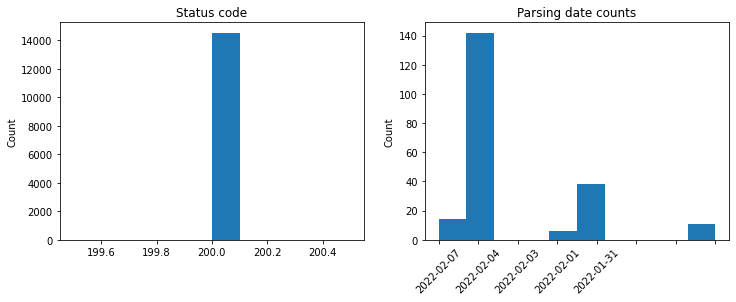

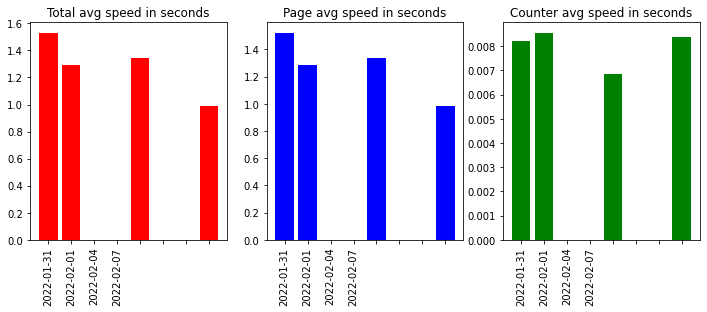

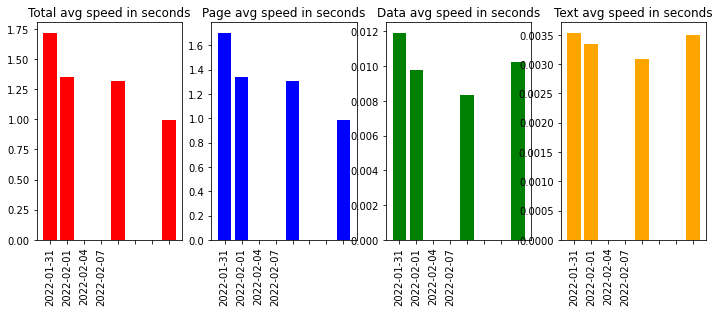


Articles counting



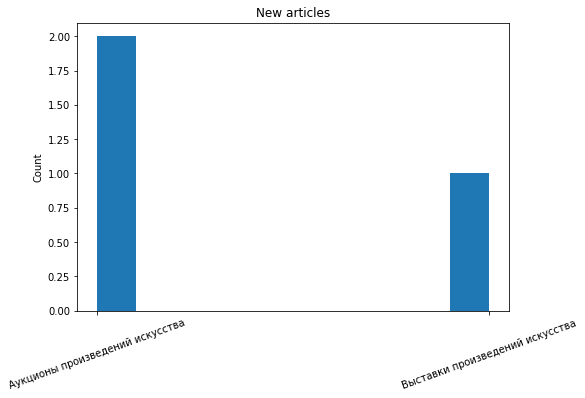


New articles titles:

Владельцы «Талисмана Наполеона» надеются продать его за $250 млн
Итоги AI аукциона № 415
Новая выставка портретов Ван Гога показывает историю изменения его психического здоровья


In [34]:
get_graphics()

In [ ]:
artinvest_pages_counter_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   page_url           74 non-null     object 
 1   page_title         74 non-null     object 
 2   records_total      74 non-null     int64  
 3   pages_total        74 non-null     int64  
 4   records_max        74 non-null     int64  
 5   records_value      74 non-null     int64  
 6   first_page_url     74 non-null     object 
 7   parsing_date       74 non-null     object 
 8   parsing_time       74 non-null     object 
 9   parsing_sec_speed  74 non-null     float64
dtypes: float64(1), int64(4), object(5)
memory usage: 5.9+ KB


In [ ]:
artinvest_news_articles_w_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12980 entries, 0 to 12979
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 12980 non-null  object 
 1   link                 12980 non-null  object 
 2   title                12980 non-null  object 
 3   short_text           12980 non-null  object 
 4   page_url             12980 non-null  object 
 5   page_title           12980 non-null  object 
 6   parsing_date         12980 non-null  object 
 7   parsing_time         12980 non-null  object 
 8   parsing_sec_speed    12980 non-null  float64
 9   long_text_url        12980 non-null  object 
 10  long_text            12980 non-null  object 
 11  sourses              12980 non-null  object 
 12  parsing_sec_speed_2  12980 non-null  float64
dtypes: float64(2), object(11)
memory usage: 1.4+ MB


In [ ]:
artinvest_long_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980 entries, 0 to 12979
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   long_text_url        12980 non-null  object 
 1   long_text            12980 non-null  object 
 2   sourses              12980 non-null  object 
 3   parsing_sec_speed_2  12980 non-null  float64
dtypes: float64(1), object(3)
memory usage: 405.8+ KB


In [ ]:
#page_statistic = page_statistic[0:0]
page_statistic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14510 entries, 0 to 14509
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   page_url           14510 non-null  object 
 1   status_code        14510 non-null  int64  
 2   encoding           14510 non-null  object 
 3   raise_for_status   0 non-null      float64
 4   parsing_date       14510 non-null  object 
 5   parsing_time       14510 non-null  object 
 6   parsing_sec_speed  14510 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 793.6+ KB


In [ ]:
#artinvest_pages_counter_stat.to_csv(art_project_path + '/artinvest_pages_counter_stat.csv', index=False)

In [ ]:
#artinvest_news_articles_data.to_csv(art_project_path + '/artinvest_news_articles_data.csv', index=False)

In [ ]:
#artinvest_long_text_df.to_csv(art_project_path + '/artinvest_long_text.csv', index=False)

In [ ]:
#page_statistic.to_csv(art_project_path + '/page_parsing_status.csv', index=False)

In [ ]:
artinvest_long_text_df = open_artinvest_long_text()

In [ ]:
artinvest_long_text_df['long_text'][0]

"['Вчера, 7 декабря 2021,  аукционный дом Sotheby’s провел в своем лондонском офисе  торги одного лота — римской мраморной скульптуры богини Афродиты, известной как  Афродита Гамильтона (по имени одного из владельцев). Лот был выставлен с  оценкой £2–3 млн, но в ходе 20-минутной аукционной борьбы между пятью  претендентами скульптура превысила эстимейт как минимум в девять раз. Новому  владельцу — некому азиатскому клиенту Sotheby’s,  чьи ставки называла менеджер по работе с клиентами Николь Чинг — Афродита  Гамильтона досталась за £18,6 млн ($24,6 млн) с учетом комиссии аукционного  дома. Это новый аукционный рекорд для античной мраморной скульптуры.', 'Афродита Гамильтона  была продана дороже, чем античный мраморный бюст Антиноя II в. н. э., за  который в 2010 году заплатили $23,8 млн. Впрочем результатам Афродиты и Антиноя  не удастся потягаться с абсолютным рекордом для древней скульптуры вообще: с  2007 года он безраздельно принадлежит миниатюрной 8-сантиметровой вавилонской  стат

In [ ]:
artinvest_long_text_df['sourses'][0]

"['https://www.artnews.com/art-news/market/hamilton-aphrodite-auction-record-1234612590/', 'https://observer.com/2021/11/a-scotsmans-beloved-hamilton-aphrodite-is-going-up-for-auction-at-sothebys/']"

In [ ]:
print(artinvest_news_articles_data['page_url'][0])
print(artinvest_news_articles_data['long_text_url'][0])

https://artinvestment.ru/news/artnews/
https://artinvestment.ru/news/artnews/20211208_Aphrodite_sale.html


In [ ]:
data = open_news_articles_data(artinvest_d)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980 entries, 0 to 12979
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               12980 non-null  object 
 1   link               12980 non-null  object 
 2   title              12980 non-null  object 
 3   short_text         12980 non-null  object 
 4   page_url           12980 non-null  object 
 5   page_title         12980 non-null  object 
 6   parsing_date       12980 non-null  object 
 7   parsing_time       12980 non-null  object 
 8   parsing_sec_speed  12980 non-null  float64
 9   long_text_url      12980 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1014.2+ KB


In [ ]:
data['date_type'] = data['date'].apply(lambda x: type(x))
data['parsing_date_type'] = data['parsing_date'].apply(lambda x: type(x))
data[['date', 'date_type', 'parsing_date', 'parsing_date_type']].head()

,date,date_type,parsing_date,parsing_date_type
0,08.12.2021,<class 'str'>,2022-01-14,<class 'str'>
1,07.12.2021,<class 'str'>,2022-01-14,<class 'str'>
2,06.12.2021,<class 'str'>,2022-01-14,<class 'str'>
3,25.11.2021,<class 'str'>,2022-01-14,<class 'str'>
4,24.11.2021,<class 'str'>,2022-01-14,<class 'str'>


In [18]:
new_data = artinvest_news_articles_w_text.loc[artinvest_news_articles_w_text['date']>=artinvest_news_articles_w_text['parsing_date'].unique()[-2]]
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 44 non-null     object 
 1   link                 44 non-null     object 
 2   title                44 non-null     object 
 3   short_text           44 non-null     object 
 4   page_url             44 non-null     object 
 5   page_title           44 non-null     object 
 6   parsing_date         44 non-null     object 
 7   parsing_time         44 non-null     object 
 8   parsing_sec_speed    44 non-null     float64
 9   long_text_url        44 non-null     object 
 10  long_text            44 non-null     object 
 11  sourses              44 non-null     object 
 12  parsing_sec_speed_2  44 non-null     float64
dtypes: float64(2), object(11)
memory usage: 4.8+ KB


In [19]:
new_data['parsing_date'].unique()

array([datetime.date(2022, 2, 7)], dtype=object)

In [21]:
new_data['date_check'] = new_data['date']>=new_data['parsing_date']
new_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,link,title,short_text,page_url,page_title,parsing_date,parsing_time,parsing_sec_speed,long_text_url,long_text,sourses,parsing_sec_speed_2,date_check
0,2022-02-04,20220204_Napoleon.html,Владельцы «Талисмана Наполеона» надеются прода...,У историков и экспертов есть сомнения в подлин...,https://artinvestment.ru/news/auctnews/,Аукционы произведений искусства,2022-02-07,09:39:19.605576,0.009557,https://artinvestment.ru/news/auctnews/2022020...,['Расположенная в Майами Аукционная компания ...,['https://news.artnet.com/opinion/talisman-of-...,0.002568,False
1,2022-02-04,20220204_Van_Gogh.html,Новая выставка портретов Ван Гога показывает и...,"В экспозиции представлено 19 работ, созданных ...",https://artinvestment.ru/news/exhibitions/,Выставки произведений искусства,2022-02-07,09:39:34.542262,0.012107,https://artinvestment.ru/news/exhibitions/2022...,['В лондонской Галерее Курто недавно открылас...,['https://news.artnet.com/art-world/in-picture...,0.002419,False
2,2022-02-04,20220204_auctionAI.html,Итоги AI аукциона № 415,"Общая выручка составила 10,3 миллиона рублей",https://artinvestment.ru/news/auctnews/,Аукционы произведений искусства,2022-02-07,09:39:19.605576,0.009557,https://artinvestment.ru/news/auctnews/2022020...,['Суммарная выручка AI аукциона № 415 достигла...,[],0.003404,False
3,2022-02-03,20220203_Givenchy.html,Christie’s выставит на продажу коллекцию Юбера...,Около 1 200 предметов из собрания модельера оц...,https://artinvestment.ru/news/auctnews/,Аукционы произведений искусства,2022-02-07,09:39:19.605576,0.009557,https://artinvestment.ru/news/auctnews/2022020...,['В честь 70-летия с момента показа первой ко...,['https://www.christies.com/en/events/hubert-d...,0.004404,False
4,2022-02-03,20220203_Venice.html,Объявлен список участников 59-й Венецианской б...,В смотре примут участие 213 художников из 58 с...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-07,09:39:05.199334,0.011757,https://artinvestment.ru/news/artnews/20220203...,['В рамках прошедшей на днях презентации 59-г...,['https://news.artnet.com/art-world/venice-bie...,0.002408,False
5,2022-02-02,20220202_dali.html,"В Вене открылась выставка, посвященная влиянию...",В экспозицию вошло около 100 работ художника,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-07,09:39:05.199334,0.011757,https://artinvestment.ru/news/artnews/20220202...,['В венском Нижнем Бельведере открылась выстав...,['https://artdaily.com/news/143461/Exhibition-...,0.002320,False
6,2022-02-02,20220202_rauschenberg.html,Фонд Роберта Раушенберга создаст онлайн-катало...,Первые два тома выйдут к 2025 году,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-07,09:39:05.199334,0.011757,https://artinvestment.ru/news/artnews/20220202...,['Фонд Роберта Раушенберга объявил о планах о...,['https://news.artnet.com/art-world/robert-rau...,0.002690,False
7,2022-02-01,20220201_rerikh.html,Архив семьи Рерихов останется в Музее Востока,"Такое решение принял Арбитражный суд Москвы, о...",https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-07,09:39:05.199334,0.011757,https://artinvestment.ru/news/artnews/20220201...,['Суд отклонил кассационную жалобу Международн...,['https://ria.ru/20220131/rerikh-1770355546.ht...,0.002145,False
8,2022-02-01,20220201_apresyan_artist.html,Персона недели: Рубен Апресян,В произведениях Рубена Апресяна воплощается ор...,https://artinvestment.ru/invest/xxicentury/,21-й век,2022-02-07,09:40:00.058470,0.010180,https://artinvestment.ru/invest/xxicentury/202...,['Рубен Леонидович Апресян родился в Москве 20...,[],0.004211,False
9,2022-02-01,20220201_auctionAI.html,Открыты 415-е торги AI Аукциона,"В каталоге 20 лотов: восемь живописных работ, ...",https://artinvestment.ru/news/auctnews/,Аукционы произведений искусства,2022-02-07,09:39:19.605576,0.009557,https://artinvestment.ru/news/auctnews/2022020...,['Комиссионный сбор с покупателей составляет ...,[],0.006321,False


In [32]:
artinvest_news_articles_w_text['parsing_date'].unique()[1]

datetime.date(2022, 2, 4)

In [30]:
artinvest_news_articles_w_text['parsing_date'].unique()

array([datetime.date(2022, 2, 7), datetime.date(2022, 2, 4),
       datetime.date(2022, 2, 1), datetime.date(2022, 1, 31),
       datetime.date(2022, 1, 27), datetime.date(2022, 1, 26),
       datetime.date(2022, 1, 25), datetime.date(2022, 1, 24),
       datetime.date(2022, 1, 21), datetime.date(2022, 1, 19),
       datetime.date(2022, 1, 18), datetime.date(2022, 1, 15),
       datetime.date(2022, 1, 14)], dtype=object)

In [29]:
artinvest_news_articles_w_text.sort_values(by=['parsing_date'], inplace=True, ascending=False)

# theartnewspaper.ru
- collected everything except dataset galleries

## Sites parsing

In [ ]:
# Parsing current theartnewspaper_data
for k1, v1 in sites_for_parsing['theartnewspaper.ru'].items():
  print(k1)

news
articles
datasets
others


In [35]:
# Get links list
def get_parsing_links_list_tanp():
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  parsing_links_list = []
  for s in sites['theartnewspaper.ru']['news']['links']:
    parsing_links_list.append(s)
  for s in sites['theartnewspaper.ru']['articles']['links']:
    parsing_links_list.append(s)
  for s in sites['theartnewspaper.ru']['others']['links']:
    parsing_links_list.append(s)
  return parsing_links_list

# Get titles list
def get_parsing_titles_list_tanp():
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  parsing_titles_list = []
  for s in sites['theartnewspaper.ru']['news']['titles']:
    parsing_titles_list.append(s)
  for s in sites['theartnewspaper.ru']['articles']['titles']:
    parsing_titles_list.append(s)
  for s in sites['theartnewspaper.ru']['others']['titles']:
    parsing_titles_list.append(s)
  return parsing_titles_list

In [36]:
# Parsing current theartnewspaper_data

def get_theartnewspaper_pages_curr_data(file, url):
  begining_a = time.time()
  #parsing_speed_a = 0
  theartnewspaper_data = open_news_articles_data(file) # 7. Open news_articles_data.csv
  theartnewspaper_data['parsing_date'] = theartnewspaper_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x))

  parsing_links_list = get_parsing_links_list_tanp() # 8.1 Get links list
  parsing_titles_list = get_parsing_titles_list_tanp() # 8.2 Get titles list

  collected_pages_a_count = 0
  for link in parsing_links_list:
    news_page = get_page(link) # 1. Collect request status

    links_list = []
    titles_list = []
    dates_list = []
    page_title_list = []
    short_text_list = []
    page_url_list = []

    start_time = time.time()
    for prenews in news_page.find_all('div', class_='postPreviewsV2Root js-fix-post-previews'):
      for a in prenews.find_all('a'):
        links_list.append(a.get('href'))
        titles_list.append(a.get('title'))
    for date in news_page.find_all('div', class_='postPreviewsItemDate'):
      dates_list.append(date.get_text())
    for p_title in news_page.find_all('div', class_='postPreviewsItemSection'):
      page_title_list.append(p_title.get_text())
      page_url_list.append(link)
    for s_text in news_page.find_all('div', class_='postPreviewsItemTitle2 js-fix-hanging js-icon-read-more'):
      short_text_list.append(s_text.get_text())

    theartnewspaper_data_new = pd.DataFrame({'date': dates_list,
                                             'link': links_list,
                                             'title': titles_list,
                                             'short_text': short_text_list,
                                             'page_url': page_url_list,
                                             'page_title': page_title_list
                                             })
    theartnewspaper_data_new['page_url'] = theartnewspaper_data_new['page_url'].apply(lambda x: x[:-1])
    theartnewspaper_data_new['parsing_date'] = datetime.now().date()
    theartnewspaper_data_new['parsing_time'] = datetime.now().time()
    theartnewspaper_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

    # For parsing long texts
    theartnewspaper_data_new['long_text_url'] = url[:-1] + theartnewspaper_data_new['link']
    long_text_url_list_new = theartnewspaper_data_new['long_text_url'].tolist()
    long_text_url_list = theartnewspaper_data['long_text_url'].tolist()
    long_text_url_list_temp = list(set(long_text_url_list_new) - set(long_text_url_list)) # only new urls - temporal list
    save_long_text_url_list_temp(long_text_url_list_temp) # 14. Save json artinvest_long_text_url_list_temp

    collected_pages_a_count += theartnewspaper_data_new['page_url'].count()
    theartnewspaper_data = pd.concat([theartnewspaper_data, theartnewspaper_data_new])
    theartnewspaper_data.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
    #parsing_speed_a += (time.time() - begining_a)

    time.sleep(5) # time for renewing json long_text_url_list_temp
    get_long_text(theartnewspaper_lt) # 11. Parsing long texts

  parsing_speed_a = time.time() - begining_a # including getting long text
  #theartnewspaper_data.to_csv(art_project_path + '/theartnewspaper_data_new.csv', index=False)
  save_df_file(theartnewspaper_data, file)

  return print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, parsing_speed_a))

In [37]:
# Parsing long texts - saving only new results from the first pages
    
def get_theartnewspaper_long_text(file):
  begining_t = time.time()
  parsing_speed_t = 0
  theartnewspaper_long_text_df = open_long_text(file) # 12. Open long_text.csv
  long_text_url_list = open_long_text_url_list_temp() # 13. Open json long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []
  add_info_list = []
  autors_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      add_info = [text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get('href'),
                  text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get_text()
                  ]
    except:
      add_info = []
    add_info_list.append(add_info)
  
    autors_l = []
    for a in text_page.find_all('a', class_='postAuthorsItem'):
      autors_l.append(a.get_text())
    autors = ', '.join(autors_l)
    autors_list.append(autors)

    long_text = []
    for lc in text_page.find_all('div', class_='leftCol630'):
      long_text.append(lc.get_text())
    long_text_list.append(long_text)

    sourses_list.append([])
    parsing_speed_list.append(time.time() - start_time)

  theartnewspaper_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list_new,
                                                   'long_text': long_text_list,
                                                   'sourses': sourses_list,
                                                   'parsing_sec_speed_2': parsing_speed_list, # for long_text collection without getting page
                                                   'autors': autors_list,
                                                   'add_info': add_info_list
                                                   })
  
  collected_pages_t_count = theartnewspaper_long_text_df_new['long_text_url'].count()
  theartnewspaper_long_text_df = pd.concat([theartnewspaper_long_text_df, theartnewspaper_long_text_df_new])
  theartnewspaper_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t += (time.time() - begining_t)

  #theartnewspaper_long_text_df.to_csv(art_project_path + file, index=False)
  save_df_file(theartnewspaper_long_text_df, file)

  return print('{} text pages have been collected\nin {} seconds\nAll text pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

In [38]:
# Parsing
start_t = time.time()
url_tanp = urls_news[2]
get_theartnewspaper_pages_curr_data(theartnewspaper_d, url_tanp)
finish_t = time.time() - start_t
print('{} seconds have passed'.format(finish_t))

2 text pages have been collected
in 1.9322314262390137 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.01567816734313965 seconds
All text pages have been collected - True
1 text pages have been collected
in 0.9007418155670166 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.015108585357666016 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.016531944274902344 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.01307535171508789 seconds
All text pages have been collected - True
0 text pages have been collected
in 0.016762733459472656 seconds
All text pages have been collected - True
3 text pages have been collected
in 2.332062244415283 seconds
All text pages have been collected - True
145 articles have been collected
in 205.46893572807312 seconds
54.888699531555176 seconds have passed


## Checking

In [39]:
# Opening
theartnewspaper_data = open_news_articles_data(theartnewspaper_d) # 7. Open news_articles_data.csv
theartnewspaper_long_text_df = open_long_text(theartnewspaper_lt) # 12. Open long_text.csv

# Dates
theartnewspaper_data['parsing_date'] = theartnewspaper_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x))
theartnewspaper_data['date'] = theartnewspaper_data['date'].dropna().apply(lambda x: date_transfomation(x))
# Sort df by date
theartnewspaper_data.sort_values(by=['parsing_date'], inplace=True, ascending=False)

In [40]:
# Checking long text
def long_text_problems_fix():
  cheking_long_text_list = []
  for url in theartnewspaper_w_text.loc[theartnewspaper_w_text['long_text'].isna()==True]['long_text_url']:
    cheking_long_text_list.append(url)

  cheking_date_list = []
  for date in theartnewspaper_w_text.loc[theartnewspaper_w_text['long_text'].isna()==True]['date']:
    cheking_date_list.append(date)

  delta = len(cheking_date_list)-len(cheking_long_text_list)

  if delta == 0:
    result = 'All long texts were found'
  else:
    result = 'News dates and long texts delta is - {}'.format(delta)
  
  return print(result)

In [41]:
theartnewspaper_w_text = theartnewspaper_data.merge(theartnewspaper_long_text_df, on='long_text_url', how='left')
long_text_problems_fix()

All long texts were found


In [43]:
# Articles counting
def get_graphics_tanp():
  print('Articles counting')
  print('')
  # today for previouse day or for some days ago
  new_data = theartnewspaper_w_text.loc[theartnewspaper_w_text['date']>=theartnewspaper_w_text['parsing_date'].unique()[1]]

  fig = plt.figure()
  axes = fig.add_axes([0,0,1,1])
  axes.hist(new_data['page_title'])
  axes.set_title('New articles')
  axes.set_ylabel('Count')
  axes.set_xticklabels(new_data['page_title'].unique(), rotation = 20)

  plt.show()

  print('')
  print('New articles titles:')
  print('')
  for t in new_data['title']:
    print(t)

Articles counting



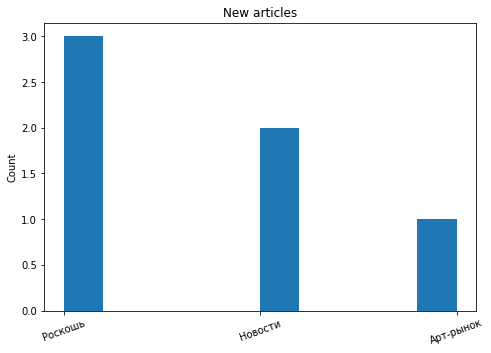


New articles titles:

Русские сюжеты
Высокое чувство
Связанные одной сеткой
Возбуждено уголовное дело из-за порчи картины Анны Лепорской
Свежий номер: музеи открываются, мумии возвращаются
Прогнозы на 2022-й: международный арт-рынок ждут изменения


In [44]:
get_graphics_tanp()

In [ ]:
theartnewspaper_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               155 non-null    object 
 1   link               155 non-null    object 
 2   title              155 non-null    object 
 3   short_text         155 non-null    object 
 4   page_url           155 non-null    object 
 5   page_title         155 non-null    object 
 6   parsing_date       155 non-null    object 
 7   parsing_time       155 non-null    object 
 8   parsing_sec_speed  155 non-null    float64
 9   long_text_url      155 non-null    object 
dtypes: float64(1), object(9)
memory usage: 12.2+ KB


In [ ]:
theartnewspaper_long_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   long_text_url        155 non-null    object 
 1   long_text            155 non-null    object 
 2   sourses              155 non-null    object 
 3   parsing_sec_speed_2  155 non-null    float64
 4   autors               22 non-null     object 
 5   add_info             22 non-null     object 
dtypes: float64(1), object(5)
memory usage: 7.4+ KB


In [ ]:
theartnewspaper_data.groupby(['page_url']).size()

page_url
https://www.theartnewspaper.ru/sections/conservation         22
https://www.theartnewspaper.ru/sections/interviu             22
https://www.theartnewspaper.ru/sections/luxury               28
https://www.theartnewspaper.ru/sections/markets              21
https://www.theartnewspaper.ru/sections/mercedes-benz         7
https://www.theartnewspaper.ru/sections/muzei-budushchego     6
https://www.theartnewspaper.ru/sections/news                 23
https://www.theartnewspaper.ru/sections/shows                26
dtype: int64

In [ ]:
theartnewspaper_data.groupby(['page_title']).size()

page_title
Cartier                 1
Арт-рынок              20
Выставки               23
Екатеринбург Россия     1
Интервью               18
Крупным планом          1
Москва Россия           1
Музей будущего          6
Назначения              1
Новости                25
Париж Франция           1
Реставрация            21
Роскошь                34
Спецпроект              1
Фестивали               1
dtype: int64

In [ ]:
theartnewspaper_w_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 0 to 154
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 155 non-null    object 
 1   link                 155 non-null    object 
 2   title                155 non-null    object 
 3   short_text           155 non-null    object 
 4   page_url             155 non-null    object 
 5   page_title           155 non-null    object 
 6   parsing_date         155 non-null    object 
 7   parsing_time         155 non-null    object 
 8   parsing_sec_speed    155 non-null    float64
 9   long_text_url        155 non-null    object 
 10  long_text            155 non-null    object 
 11  sourses              155 non-null    object 
 12  parsing_sec_speed_2  155 non-null    float64
 13  autors               22 non-null     object 
 14  add_info             22 non-null     object 
dtypes: float64(2), object(13)
memory usage: 

In [ ]:
theartnewspaper_w_text.loc[theartnewspaper_long_text_df['autors'].isna()==False].groupby(['page_url']).size()

page_url
https://www.theartnewspaper.ru/sections/luxury      6
https://www.theartnewspaper.ru/sections/markets     1
https://www.theartnewspaper.ru/sections/news       11
https://www.theartnewspaper.ru/sections/shows       4
dtype: int64

In [ ]:
autors_l = ['The Art Newspaper Russia']
autors = ', '.join(autors_l)
autors

'The Art Newspaper Russia'